## 卷積神經網路(Convolutional Neural Network, CNN)

### 全連接(fully-connected)層神經網路與卷積神經網路(CNN)

- 全連接(fully-connected)層神經網路的簡單結構

      [輸入資料] -> [(Affine-ReLU)-(Affine-ReLU)-(Affine-Softmax)] -> [輸出資料]

- 卷積神經網路(CNN)的簡單結構

      [輸入資料] -> [(Conv-ReLU-Pooling)-(Affine-ReLU)-(Affine-Softmax)] -> [輸出資料] 

### 卷積層(Convolution layer)

#### 全連接層的問題

- 忽略資料的形狀(形狀含有重要的空間資訊，將多維的輸入資料轉換成一維的資料後，會無法發揮與形狀有關的資料訊息)

  Example: 三維影像資料中，類似的空間有著相似的像素; RGB 各色板之間，具有緊密相連的關聯性

  $ \rightarrow $ 卷積層能維持輸入與輸出資料的形狀，可以正確了解影像等含有形狀的資料

#### 卷積層的運算原理

- 卷積的基本計算

$$ 輸入資料 \otimes 濾鏡[或稱作 核(kernel)](神經網路的權重) \rightarrow 輸出資料 $$

      - 輸入特徵圖(input feature map): CNN 卷積層的輸入資料
      
      - 輸出特徵圖(output feature map): CNN 卷積層的輸出資料

- 填補(Padding): 進行卷積處理前，在輸入資料的周圍填上固定的資料(如: 0)

  目的: 
  
      調整輸出資料的大小 (因為每次卷積運算時，空間就會縮小，到了某階段，輸出的空間大小變成 1，就無法再進行卷積運算。而藉由填補的動作，可以確保固定的空間大小，將資料傳遞給下一層)



- 步幅(stride): 輸入資料套用濾鏡的位置間隔


- 輸出資料的大小計算:

$$ OH = \frac{H + 2P - FH}{S} + 1 $$

$$ OW = \frac{W + 2P - FW}{S} + 1 $$

    輸入資料大小: (H, W)，濾鏡大小: (FH, FW)，填補大小: P，步幅間隔: S，輸出資料大小: (OH, OW)

#### 三維資料的卷積層計算 (輸入資料的色版數必須和濾鏡的色版數相同)

- 單一輸入資料 (色版數: C、高度: H、寬度: W)、單一濾鏡 (色版數: C、濾鏡高度: FH、濾鏡寬度: FW) 

$$ 輸入資料(C, H, W) \otimes 濾鏡(C, FH, FW) + 偏權值(1, 1, 1) \rightarrow 輸出資料(1, OH, OW) $$

- 單一輸入資料 (色版數: C、高度: H、寬度: W)、多個濾鏡 (濾鏡數: FN、色版數: C、濾鏡高度: FH、濾鏡寬度: FW) 

$$ 輸入資料(C, H, W) \otimes 濾鏡(FN, C, FH, FW) + 偏權值(FN, 1, 1) \rightarrow 輸出資料(FN, OH, OW) $$

- **批次處理:** 多個輸入資料 (資料數: N、色版數: C、高度: H、寬度: W)、多個濾鏡 (濾鏡數: FN、色版數: C、濾鏡高度:  FH、濾鏡寬度: FW) 

$$ 輸入資料(N, C, H, W) \otimes 濾鏡(FN, C, FH, FW) + 偏權值(FN, 1, 1) \rightarrow 輸出資料(N, FN, OH, OW) $$

### 池化層(Pooling layer)

#### 池化層的運算

- 最大池化(max pooling): 從目標區域中取的最大值

- 平均池化(average pooling): 計算目標區域的平均值

$ \rightarrow $ 池化的區域大小與步幅通常設定成相同數值

Example: 3 $ \times $ 3 的視窗，步幅設定為 3

#### 池化層的特色

- 沒有學習參數

- 輸入資料與輸出資料的色板數量不變

- 對微小位置的變化很穩健(robust) [輸入資料若出現小偏差，池化仍會回傳相同的結果]


### 執行卷積層

#### im2col (image to column) 函數 (用來處理卷積層的向前傳播)

- 把影像轉換成陣列 (將含有批次數量的輸入資料依次水平展開成一列，來組成二維的資料)

- 將濾鏡依次垂直展開成一行，來組成二維的資料

#### im2col 函數中的參數

- input_data: 四維陣列(資料數量、色版數、高度、寬度)組成的輸入資料
- filter_h: 濾鏡的高度
- filter_w: 濾鏡的寬度
- stride: 步幅
- pad: 填補


In [1]:
import numpy as np

# 定義 im2col 函數
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):

    N, C, H, W = input_data.shape
    out_h = int( (H + 2 * pad - filter_h) / stride ) + 1
    out_w = int( (W + 2 * pad - filter_w) / stride ) + 1

    # 對數據進行填充(待填充的數據、填充的形狀(x,y):前面 x 個，後面 y 個、填充的方法: 'constant')
    img = np.pad(input_data, [(0, 0), (0, 0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        
        y_max = y + stride * out_h
        
        for x in range(filter_w):
            x_max = x + stride * out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N * out_h * out_w, -1)
    
    return col

# 測試
x1 = np.random.rand(10, 3, 7 ,7)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape)

(90, 75)


#### col2im (column to image) 函數 (用來處理卷積層的向後傳播)


In [2]:
import numpy as np

# 定義 col2im 函數
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):

    N, C, H, W = input_shape
    out_h = int( (H + 2 * pad - filter_h) / stride ) + 1
    out_w = int( (W + 2 * pad - filter_w) / stride ) + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2 * pad + stride - 1, W + 2 * pad + stride - 1))
    
    for y in range(filter_h):
        
        y_max = y + stride * out_h
        
        for x in range(filter_w):
            
            x_max = x + stride * out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]


#### 建立卷積層的類別 (處理過程類似於全連接層神經網路中的 Affine 層)

In [3]:
import numpy as np

class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 反向傳播時會用到的參數
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 反向傳播權重與偏權值的變化參數
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2 * self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2 * self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        # 展開濾鏡(-1 用來整合元素數量)
        col_W = self.W.reshape(FN, -1).T
        out = np.dot(col, col_W) + self.b
        
        # transpose 用來更換多維陣列各軸的順序[Ex: 索引值 (0, 1, 2, 3) -> (0, 3, 2, 1)]
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

### 執行池化層

#### 池化層的執行過程: (向前傳播)
1. 展開輸入資料 

       - 使用 im2col 函數
       - 輸入的資料中，套用池化層的區域會依照色版獨立展開
    
2. 計算每列的最大值

3. 調整成適當的輸出大小

In [4]:
import numpy as np

# 建立池化層類別
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        # 第一步: 展開
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)

        # 第二步: 計算每列最大值
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        
        #第三步: 調整形狀
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

### 執行 CNN 影像辨識

#### 建立卷積神經網路(CNN)

In [5]:
import numpy as np
from collections import OrderedDict
from ProcessBar.Process_Bar import *
from common.layers import *

#------------------------------------------------------------------------------------------------------
# 定義 ReLU 層類別
class Relu_Layer:
    def __init__(self):
        # 實例變數 mask 為 True/False 形成的 Numpy array
        self.mask = None
    
    def forward(self, x):
        # x 小於或等於零為 True, 大於零為 False
        self.mask = (x <= 0)
        out = x.copy()
        # 將 mask 元素為 True 的位置設定成零 (x <= 0 的值變為零)
        out[self.mask] = 0
        
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        
        return dx

# 定義批次處理的 Affine 層
class Affine_Layer:
    def __init__(self, W, b):
        self.X = None
        self.original_X_shape = None
        self.W = W
        self.b = b
        self.dW = None
        self.db = None
        
    def forward(self, X):
        # 張量形式
        self.original_X_shape = X.shape
        X = X.reshape(X.shape[0], -1)
        
        self.X = X
        out = np.dot(X, self.W) + self.b
        
        return out 
    
    def backward(self, dout):
        dX = np.dot(dout, self.W.T)
        self.dW = np.dot(self.X.T, dout)
        # 偏權值的反向傳播: 假設資料有 N 組，統計這 N 組資料相同維度的微分
        # axis = 0: 針對第零軸(以資料為單位的軸)做元素值的加總
        self.db = np.sum(dout, axis = 0)
        
        # 恢復輸入數據的形狀(張量形式)
        dX = dX.reshape(*self.original_X_shape)
        
        return dX

# 定義 softmax 函數
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        
        return y.T 

    x = x - np.max(x)
    
    return np.exp(x) / np.sum(np.exp(x))  

# 小批次處理的交叉熵誤差(cross entropy error)- t 使用 one-hot-label    
def batch_cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 找出每一組 t 資料中正確標籤的 index
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    
    # 將每一組 y 資料的值列出(對應於 t 資料的正確標籤 index)，取 log 再加總
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size
    
# 定義 Softmax-with-loss 層
class Softmax_With_Loss_Layer:
    def __init__(self):
        self.loss = None
        self.y = None 
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        
        if self.t.size == self.y.size: 
            dx = (self.y - self.t) / batch_size
        
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

#------------------------------------------------------------------------------------------------------
# 建立卷積神經網路的類別
class SimpleConvNet:
    
    # 建立引數(input_dim、conv_param 卷基層的超參數字典、hidden_size、output_size、weight_init_std)
    def __init__(self, input_dim=(1, 28, 28), conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1}, 
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        
        input_size = input_dim[1]
        conv_output_size = int((input_size + 2 * filter_pad - filter_size) / filter_stride) + 1
        pool_output_size = int(filter_num * (conv_output_size / 2) * (conv_output_size / 2))

        # 權重初始化
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 建立各層
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu_Layer()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine_Layer(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu_Layer()
        self.layers['Affine2'] = Affine_Layer(self.params['W3'], self.params['b3'])

        self.last_layer = Softmax_With_Loss_Layer()

    def forward_predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        y = self.forward_predict(x)
        
        return self.last_layer.forward(y, t)

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
    
    def accuracy(self, x, t, batch_size=100):
        
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.forward_predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

#### 誤差反向傳播法的卷積神經網路(CNN)學習

In [6]:
# 定義 Adam 最佳化類別
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():

            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key] ** 2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from ProcessBar.Process_Bar import *

#取得資料
(x_train, t_train), (x_test, t_test) = load_mnist(flatten = False)

#設定神經網路
network = SimpleConvNet(input_dim=(1,28,28), conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1}, 
                        hidden_size=100, output_size=10, weight_init_std=0.01)

#設定超參數
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
lr = 0.001

#建立訓練過程中的損失函數值列表
train_loss_list = []

#建立訓練與測試資料的辯識準確度列表
train_acc_list = []
test_acc_list = []

# 每一週期的重複次數
iter_per_epoch = max(train_size/batch_size, 1)

#建立進度條
process_bar = ShowProcess(iters_num, '計算完成')

#執行小批次學習
for i in range(iters_num):
    #取得小批次
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    #利用誤差反向傳播法計算梯度
    grad = network.gradient(x_batch, t_batch)
    
    #更新參數
    # 使用 Adam 最佳化
    optimizer = Adam(lr=0.001, beta1=0.9, beta2=0.999)
    optimizer.update(network.params, grad)
    # 使用 SGD 最佳化
    #for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        #network.params[key] -= lr * grad[key]
        
    #紀錄學習過程
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    #計算一個周期的辯識準確度
    if i % iter_per_epoch == 0 and i != 0 :
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("(train acc, test acc) = " + "(" + str(train_acc) + "," + str(test_acc) + ")")
    
    #顯示當前進度
    process_bar.show_process()
    time.sleep(0.01)

(train acc, test acc) = (0.946916666667,0.9471)----]6.00%
(train acc, test acc) = (0.975666666667,0.9744)----]12.00%
(train acc, test acc) = (0.980433333333,0.981)-----]18.00%
(train acc, test acc) = (0.983833333333,0.9836)----]24.00%
(train acc, test acc) = (0.985716666667,0.9827)----]30.00%
(train acc, test acc) = (0.986566666667,0.9854)----]36.00%
(train acc, test acc) = (0.988133333333,0.9845)----]42.00%
(train acc, test acc) = (0.9892,0.9847)------------]48.00%
(train acc, test acc) = (0.988783333333,0.9848)----]54.00%
(train acc, test acc) = (0.989333333333,0.9855)----]60.00%
(train acc, test acc) = (0.987933333333,0.983)-----]66.00%
(train acc, test acc) = (0.9901,0.9872)------------]72.00%
(train acc, test acc) = (0.988233333333,0.9845)----]78.00%
(train acc, test acc) = (0.987166666667,0.9817)----]84.00%
(train acc, test acc) = (0.98665,0.9811)∎∎∎∎∎∎-----]90.00%
(train acc, test acc) = (0.977416666667,0.9695)∎∎--]96.00%
[∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎]100.0

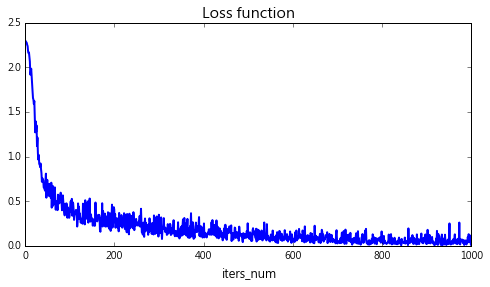

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(np.arange(iters_num/10), train_loss_list[:int(iters_num/10)], color='b', lw=2)
ax.set_ylim(0, 2.5)
ax.set_title("Loss function", fontsize = 15)
ax.set_xlabel("iters_num", fontsize = 12)

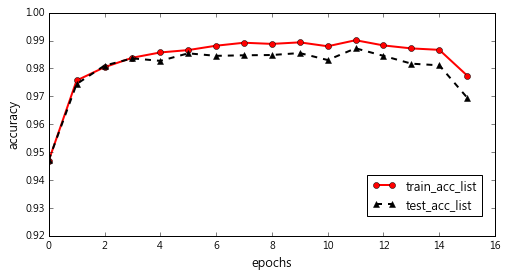

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(np.arange(int(iters_num/iter_per_epoch)), train_acc_list, color='r', linestyle="-", marker="o", lw=2, label="train_acc_list")
ax.plot(np.arange(int(iters_num/iter_per_epoch)), test_acc_list, color='k', linestyle="--", marker="^", lw=2, label="test_acc_list")
ax.set_ylim(0.92, 1)
ax.set_xlabel("epochs", fontsize = 12)
ax.set_ylabel("accuracy", fontsize = 12)
plt.legend(loc='upper left', bbox_to_anchor=(0.7, 0.3))